## Imports

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
# import and read csv
import pandas as pd
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from ast import literal_eval
import numpy as np
import string
import re

import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import MultiLabelBinarizer

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
%matplotlib inline
pd.set_option('display.max_colwidth', 300)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Perform exploratory data analysis

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
  
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


link = "https://drive.google.com/file/d/18ZGW-c3oDNIEmBFUfzXl2v0v04mkSlJc/view"
  
# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('arxiv.csv')  
  
arxiv_data = pd.read_csv('arxiv.csv')
arxiv_data.head()

,titles,summaries,terms
0,Revealing the Field Sub-subgiant Population Using a Catalog of Active Giant Stars and Gaia EDR3,"Sub-subgiant stars (SSGs) fall below the subgiant branch and/or red of the\ngiant branch in open and globular clusters, an area of the color-magnitude\ndiagram (CMD) not populated by standard stellar evolution tracks. One\nhypothesis is that SSGs result from rapid rotation in subgiants or giants...","['astro-ph.SR', 'astro-ph.GA']"
1,ALMA detection of ethyl cyanide and methyl formate in the hot molecular core IRAS 18566+0408,"In millimeter/submillimeter wavelength, the studies of the complex molecular\nemission lines towards the hot molecular cores demonstrate valuable details\nabout the chemical composition and massive star formation processes. We present\nthe interferometric detection of rotational molecular emissi...",['astro-ph.GA']
2,Accretion processes in the galaxy cluster Hydra A/Abell 780,"Clusters of galaxies evolve and accrete mass, mostly from small galaxy\nsystems. Our aim is to study the velocity field of the galaxy cluster Abell\n780, which is known for the powerful radio source Hydra A at its center and\nwhere a spectacular X-ray tail associated with the galaxy LEDA 87445 h...","['astro-ph.CO', 'astro-ph.GA']"
3,Radio astronomy locates the neutrino origin in bright blazars,"High-energy astrophysical neutrinos have been observed by several telescopes\nin the last decade, but their sources still remained unknown. We address the\nproblem of locating astrophysical neutrinos' sources in a statistical manner.\nWe show that blazars positionally associated with IceCube neu...","['astro-ph.HE', 'astro-ph.GA']"
4,The extragalactic $γ$-ray background: imprints from the physical properties and evolution of star-forming galaxy populations,"Star-forming galaxies (SFGs) are expected to harbour an abundant reservoir of\ncosmic rays (CRs). At GeV energies, these CRs can undergo hadronic interactions\nwith interstellar gases to produce $\gamma$-rays, and the unresolved\n$\gamma$-ray emission from populations of SFGs form a component of...","['astro-ph.GA', 'astro-ph.HE']"
...,...,...,...
89331,On the nature of the candidate T-Tauri star V501 Aurigae,"We report new multi-colour photometry and high-resolution spectroscopic\nobservations of the long-period variable V501 Aur, previously considered to be\na weak-lined T-Tauri star belonging to the Taurus-Auriga star-forming region.\nThe spectroscopic observations reveal that V501 Aur is a single-...",['astro-ph.SR']
89332,3D modelling of accretion disc in eclipsing binary system V1239 Her,"We present the results of 3D-hydrodynamical simulations of accretion flow in\nthe eclipsing dwarf nova V1239 Her in quiescence. The model includes the\noptical star filling its Roche lobe, a gas stream emanating from the inner\nLagrangian point of the binary system, and the accretion disc struct...",['astro-ph.SR']
89333,The evolution of magnetic hot massive stars: Implementation of the quantitative influence of surface magnetic fields in modern models of stellar evolution,"Large-scale dipolar surface magnetic fields have been detected in a fraction\nof OB stars, however only few stellar evolution models of massive stars have\nconsidered the impact of these fossil fields. We are performing 1D\nhydrodynamical model calculations taking into account evolutionary conse...",['astro-ph.SR']
89334,The growth of carbon chains in IRC+10216 mapped with ALMA,"Linear carbon chains are common in various types of astronomical molecular\nsources. Possible formation mechanisms involve both bottom-up and top-down\nroutes. We have carried out a combined observational and modeling study of the\nformation of carbon chains in the C-star envelope IRC+10216, whe...","['astro-ph.SR', 'astro-ph.GA']"


In [ ]:
print(f"There are {len(arxiv_data)} rows in the dataset.")

There are 89336 rows in the dataset.


In [ ]:
total_duplicate_titles = sum(arxiv_data["titles"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")

There are 19134 duplicate titles.


In [ ]:
arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")

# There are some terms with occurrence as low as 1.
print(sum(arxiv_data["terms"].value_counts() == 1))

# How many unique terms?
print(arxiv_data["terms"].nunique())

There are 70202 rows in the deduplicated dataset.
22
152


In [ ]:
arxiv_data_filtered = arxiv_data

## Convert the string labels to lists of strings

In [ ]:
arxiv_data_filtered["terms"] = arxiv_data_filtered["terms"].apply(
    lambda x: literal_eval(x)
)
arxiv_data_filtered["terms"].values[:5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array([list(['astro-ph.SR', 'astro-ph.GA']), list(['astro-ph.GA']),
       list(['astro-ph.CO', 'astro-ph.GA']),
       list(['astro-ph.HE', 'astro-ph.GA']),
       list(['astro-ph.GA', 'astro-ph.HE'])], dtype=object)

In [ ]:
dict_len = {}
for i in range(arxiv_data_filtered.shape[0]):
    if(len(arxiv_data_filtered.iloc[i]["terms"]) not in dict_len):
        dict_len[len(arxiv_data_filtered.iloc[i]["terms"])] = 1
    else:
        dict_len[len(arxiv_data_filtered.iloc[i]["terms"])] += 1
print("Occurancy of number of labels in a term: ")
dict_len = dict(sorted(dict_len.items(), key=lambda item: item[1], reverse=True))
for k, v in dict_len.items():
    print(f" - The number of paper have {k} labels in it's term: {v}")

Occurancy of number of labels in a term: 
 - The number of paper have 1 labels in it's term: 46399
 - The number of paper have 2 labels in it's term: 20635
 - The number of paper have 3 labels in it's term: 2904
 - The number of paper have 4 labels in it's term: 209
 - The number of paper have 5 labels in it's term: 54
 - The number of paper have 6 labels in it's term: 1


##Pre-processing dataset


In [ ]:
all_terms = sum(arxiv_data_filtered["terms"],[])
all_terms = nltk.FreqDist(all_terms) 
# create dataframe
all_terms_df = pd.DataFrame({'Term': list(all_terms.keys()), 
                              'Count': list(all_terms.values())})

In [ ]:
def clean_text(text):
  # remove new line characters
  text = re.sub(r"\n", " ", text)
  # remove email
  text = re.sub(r"([A-Za-z0-9_.+-]+@[A-Za-z0-9-]+\.?[A-Za-z0-9-.]+)", "", text)
  # remove url
  text = re.sub(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*", "", text)
  # remove punctuation
  text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
  # remove words including numbers
  text = re.sub(r"\w*\d\w*", "", text)
  # remove single character and duplicated words
  # text = ' '.join(word for word in list(set(text.split())) if len(word) > 1)
  # replace multiple whitespace by one whitespace
  text = re.sub(r"\s+", " ", text)
  # lower all text
  text = text.lower()
  # strip all text
  text = text.strip()
  return text

In [ ]:
def remove_stopwords(text):
  stop_words = stopwords.words('english')
  cleaned_text = []
  # turn text to a list of words
  word_list = text.split()
  for word in word_list:
    if word not in stop_words:
      cleaned_text.append(word)
  return ' '.join(cleaned_text)

In [ ]:
def lemmatize_text(text):
  wnl = WordNetLemmatizer()
  pos_text = pos_tag(word_tokenize(text))
  cleaned_text = []
  for word, tag in pos_text:
    wntag = tag[0].lower()
    wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
    if not wntag:
      lem_word = word
    else:
      lem_word = wnl.lemmatize(word, wntag)
    cleaned_text.append(lem_word)
  return ' '.join(cleaned_text)

In [ ]:
arxiv_data_filtered['summaries'] = arxiv_data_filtered['summaries'].apply(clean_text)
arxiv_data_filtered['summaries'] = arxiv_data_filtered['summaries'].apply(remove_stopwords)
arxiv_data_filtered['summaries'] = arxiv_data_filtered['summaries'].apply(lemmatize_text)
arxiv_data_filtered['summaries']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

0        sub subgiant star ssgs fall subgiant branch red giant branch open globular cluster area color magnitude diagram cmd populate standard stellar evolution track one hypothesis ssgs result rapid rotation subgiants giant due tidal synchronization close binary strong magnetic field generate inhibit co...
1        millimeter submillimeter wavelength study complex molecular emission line towards hot molecular core demonstrate valuable detail chemical composition massive star formation process present interferometric detection rotational molecular emission line complex organic specie ethyl cyanide c h cn me...
2        cluster galaxy evolve accrete mass mostly small galaxy system aim study velocity field galaxy cluster abell know powerful radio source hydra center spectacular x ray tail associate galaxy leda discover analysis base new spectroscopic data hundred galaxy obtain italian telescopio nazionale em gal...
3        high energy astrophysical neutrino observe several telescope las

## Split training set, validation set and test set

In [ ]:
test_split = 0.3

# Initial train and test split.
train_df, test_df = train_test_split(
    arxiv_data_filtered,
    test_size=test_split,
    # stratify=arxiv_data_filtered["terms"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 49141
Number of rows in validation set: 10530
Number of rows in test set: 10531


## Multi-label binarization

In [ ]:
terms = tf.ragged.constant(train_df["terms"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)


Vocabulary:

['[UNK]', 'astro-ph.GA', 'astro-ph.SR', 'astro-ph.EP', 'astro-ph.HE', 'astro-ph.IM', 'astro-ph.CO']


In [ ]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['astro-ph.GA']
Label-binarized representation: [[0. 1. 0. 0. 0. 0. 0.]]


## Data preprocessing and `tf.data.Dataset` objects


In [ ]:
batch_size = 128
auto = tf.data.AUTOTUNE


def unify_text_length(text, label):
    return tf.expand_dims(text, -1), label


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["summaries"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    dataset = dataset.map(unify_text_length, num_parallel_calls=auto).cache()
    return dataset.batch(batch_size)


In [ ]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

## Dataset preview

In [ ]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text[0]}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'study bright b intermediate redshift z disc dominate n b galaxy hst acs chandra deep field south rest frame b band find new class bulge brighter compact ellipticals refer bright compact bulge bcbs resemble neither classical pseudo bulge constitute total bulge population redshift examine free bulge disc decomposition sample elliptical galaxy sample simard et al find bulge classify bcbs local universe bulge total ratio b disc galaxy bcbs factor larger classical pseudo bulge bcbs time massive classical pseudo bulge although disc galaxy bcbs host massive dominant bulge type specific star formation rate time higher disc galaxy contrary expectation massive compact bulge would lead lower star formation rate speculate bcb host disc galaxy descendant massive compact passive elliptical galaxy observe higher redshift high redshift ellipticals lack local counterpart possibly evolve acquire compact disc around overall property bcbs support picture galaxy assembly younger disc accrete ar

## Vectorization

In [ ]:
train_df["total_words"] = train_df["summaries"].str.split().str.len()
vocabulary_size = train_df["total_words"].max()
print(f"Vocabulary size: {vocabulary_size}")

Vocabulary size: 241


In [ ]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf-idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)


## Create a text classification model


In [ ]:

def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dropout(0.2),
            layers.Dense(512, activation="relu"),
            layers.Dropout(0.1),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]
    )
    return shallow_mlp_model


## Train the model

Epoch 1/10
384/384 [==============================] - 11s 25ms/step - loss: 0.4881 - precision: 0.6067 - recall: 0.4191 - val_loss: 0.2526 - val_precision: 0.7831 - val_recall: 0.6857
Epoch 2/10
384/384 [==============================] - 9s 23ms/step - loss: 0.2600 - precision: 0.7862 - recall: 0.6511 - val_loss: 0.2330 - val_precision: 0.8203 - val_recall: 0.6896
Epoch 3/10
384/384 [==============================] - 9s 23ms/step - loss: 0.2380 - precision: 0.8113 - recall: 0.6840 - val_loss: 0.2241 - val_precision: 0.8230 - val_recall: 0.7043
Epoch 4/10
384/384 [==============================] - 9s 24ms/step - loss: 0.2260 - precision: 0.8220 - recall: 0.6986 - val_loss: 0.2199 - val_precision: 0.8247 - val_recall: 0.7053
Epoch 5/10
384/384 [==============================] - 9s 23ms/step - loss: 0.2177 - precision: 0.8290 - recall: 0.7073 - val_loss: 0.2150 - val_precision: 0.8295 - val_recall: 0.7081
Epoch 6/10
384/384 [==============================] - 9s 23ms/step - loss: 0.2113 - 

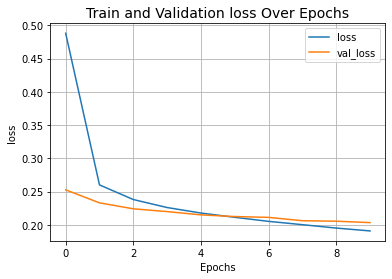

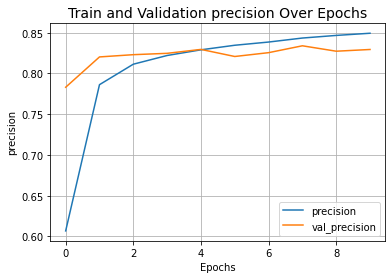

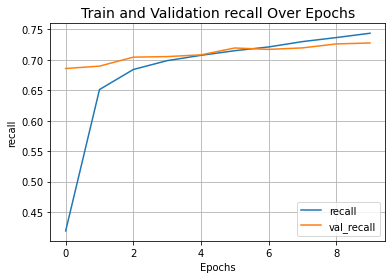

In [ ]:
epochs = 10

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    # loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate = 0.005, beta_1=0.85, beta_2=0.99, epsilon=1e-04), metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    loss="binary_crossentropy", optimizer=keras.optimizers.Adam(), metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs,
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("precision")
plot_result("recall")

## Evaluate the model

###Exact Match Radio

In [ ]:
def get_y_true_and_y_pred_prob_value():
    model_for_evaluate = keras.Sequential([text_vectorizer, shallow_mlp_model])
    evaluate_dataset = make_dataset(test_df, is_train=False)

    y_true = []
    y_pred_prob = []

    for text_batch, label_batch in evaluate_dataset:
        predicted_probabilities = model_for_evaluate.predict(text_batch)
        for i, text in enumerate(text_batch):
            label = label_batch[i].numpy()[None, ...]
            y_true.append(label[0])
            y_pred_prob.append(predicted_probabilities[i])
    y_true = np.array(y_true)
    y_pred_prob = np.array(y_pred_prob)
    return y_true, y_pred_prob


In [ ]:
def get_y_pred(y_pred_prob, k=3, threshold=0.5):
    y_pred = []
    for pred in y_pred_prob:
        top_k_labels = [
            x
            for _, x in sorted(
                zip(pred, lookup.get_vocabulary()),
                key=lambda pair: pair[0],
                reverse=True,
            )
        ][:k]
        y_top_k_labels = np.zeros(y_pred_prob[0].shape[0])
        for j in range(len(vocab)):
            if(vocab[j] in top_k_labels):
                if(pred[j] > threshold):
                    y_top_k_labels[j] = 1
                else:
                    top_k_labels.remove(vocab[j])
        y_pred.append(y_top_k_labels)
    y_pred = np.array(y_pred)   
    return y_pred


In [ ]:
y_true, y_pred_prob = get_y_true_and_y_pred_prob_value()
for k in range(1,7,1):
    for threshold in np.arange(0.3,0.8,0.1):
        y_pred = get_y_pred(y_pred_prob, k, threshold)
        number_of_test = test_df.shape[0]
        from sklearn.metrics import accuracy_score
        acc = accuracy_score(y_true, y_pred)
        print(f"With k = {k} and threshold = {round(threshold,1)} - Exact Match Radio accuracy on the test set: {round(acc * 100, 2)}%")

With k = 1 and threshold = 0.3 - Exact Match Radio accuracy on the test set: 57.32%
With k = 1 and threshold = 0.4 - Exact Match Radio accuracy on the test set: 57.23%
With k = 1 and threshold = 0.5 - Exact Match Radio accuracy on the test set: 56.84%
With k = 1 and threshold = 0.6 - Exact Match Radio accuracy on the test set: 55.64%
With k = 1 and threshold = 0.7 - Exact Match Radio accuracy on the test set: 53.33%
With k = 2 and threshold = 0.3 - Exact Match Radio accuracy on the test set: 52.39%
With k = 2 and threshold = 0.4 - Exact Match Radio accuracy on the test set: 57.21%
With k = 2 and threshold = 0.5 - Exact Match Radio accuracy on the test set: 58.76%
With k = 2 and threshold = 0.6 - Exact Match Radio accuracy on the test set: 57.4%
With k = 2 and threshold = 0.7 - Exact Match Radio accuracy on the test set: 54.42%
With k = 3 and threshold = 0.3 - Exact Match Radio accuracy on the test set: 51.85%
With k = 3 and threshold = 0.4 - Exact Match Radio accuracy on the test set: 

### Hamming Loss

In [ ]:
from sklearn.metrics import hamming_loss
y_true, y_pred_prob = get_y_true_and_y_pred_prob_value()
y_pred = get_y_pred(y_pred_prob, k=3, threshold=0.5)
hml = hamming_loss(y_true, y_pred)
print(f"Hamming Loss = {round(hml, 5)}")

Hamming Loss = 0.08054


### Confusion Matrix Metrics

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

y_true, y_pred_prob = get_y_true_and_y_pred_prob_value()
y_pred = get_y_pred(y_pred_prob, k=3, threshold=0.5)

m = multilabel_confusion_matrix(y_true, y_pred)

for i in range(1,len(m)):
    print("Multilabel_confusion_matrix_of: "+vocab[i])
    print(m[i])
    print()
    # print(vocab[i])

Multilabel_confusion_matrix_of: astro-ph.GA
[[6585  603]
 [ 580 2763]]

Multilabel_confusion_matrix_of: astro-ph.SR
[[7212  407]
 [ 990 1922]]

Multilabel_confusion_matrix_of: astro-ph.EP
[[7776  220]
 [ 392 2143]]

Multilabel_confusion_matrix_of: astro-ph.HE
[[8114  251]
 [ 621 1545]]

Multilabel_confusion_matrix_of: astro-ph.IM
[[8221  238]
 [ 776 1296]]

Multilabel_confusion_matrix_of: astro-ph.CO
[[8593  356]
 [ 503 1079]]



### Precision, Recall, F1_score, micro-average, macro-average metrics

In [ ]:
from sklearn.metrics import classification_report

y_pred = get_y_pred(y_pred_prob, k=3, threshold=0.5)

print(classification_report(y_true, y_pred,target_names=vocab, zero_division = 0))

              precision    recall  f1-score   support

       [UNK]       0.00      0.00      0.00         0
 astro-ph.GA       0.82      0.83      0.82      3343
 astro-ph.SR       0.83      0.66      0.73      2912
 astro-ph.EP       0.91      0.85      0.88      2535
 astro-ph.HE       0.86      0.71      0.78      2166
 astro-ph.IM       0.84      0.63      0.72      2072
 astro-ph.CO       0.75      0.68      0.72      1582

   micro avg       0.84      0.74      0.78     14610
   macro avg       0.72      0.62      0.66     14610
weighted avg       0.84      0.74      0.78     14610
 samples avg       0.85      0.80      0.80     14610



### Exist 1 in Top k predicts is true Accuracy

In [ ]:
def top_k_predict_is_true_accuracy(y_true, y_pred_prob, k=3, threshold = 0.5):
    score = 0
    for i in range(len(y_pred_prob)):
            top_k_labels = [
                x
                for _, x in sorted(
                    zip(y_pred_prob[i], lookup.get_vocabulary()),
                    key=lambda pair: pair[0],
                    reverse=True,
                )
            ][:k]
            y_top_k_labels = np.zeros(y_pred_prob[0].shape[0])
            for label in top_k_labels:
                if(y_true[i][vocab.index(label)] == 1):
                    score += 1
                    break
    return score/len(y_pred_prob)

acc = top_k_predict_is_true_accuracy(y_true, y_pred_prob, 3, 0.5)
print(f"Accuracy: {round(acc, 5)}")

Accuracy: 0.98917


## Inference

In [ ]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

k=6

# Perform inference.
for i, text in enumerate(text_batch[:50]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text[0]}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_k_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:k]
    predicted_proba.sort(reverse = True)
    for i in reversed(range(len(predicted_proba)-1)):
        if(predicted_proba[i] < 0.3 and len(top_k_labels) > 0):
            top_k_labels.pop(i)
    print(f"Predicted Label(s): ({', '.join([label for label in top_k_labels])})")
    print(" ")

Abstract: b'common variable star classifier build goal produce correct class label leave much multi task capability deep neural network unexplored present periodic light curve classifier combine recurrent neural network autoencoder unsupervised feature extraction dual purpose estimation network supervise classification novelty detection estimation network optimize gaussian mixture model reduce dimension feature space gaussian component corresponds variable class estimation network basic structure single hidden layer attains cross validation classification accuracy par conventional workhorse random forest classifier addition photometric feature network capable detect previously unseen type variability precision recall score simultaneous train autoencoder estimation network find mutually beneficial result faster autoencoder convergence superior classification novelty detection performance estimation network also deliver adequate result even optimize pre train autoencoder feature suggest 